# 📎UTS Telkom Datasets - MLP (PyTorch)

Dataset shape: (515345, 91)

Statistik Dasar:
       count         mean         std         min         25%         50%  \
0   515345.0  1998.397082   10.931046  1922.00000  1994.00000  2002.00000   
1   515345.0    43.387126    6.067558     1.74900    39.95469    44.25850   
2   515345.0     1.289554   51.580351  -337.09250   -26.05952     8.41785   
3   515345.0     8.658347   35.268585  -301.00506   -11.46271    10.47632   
4   515345.0     1.164124   16.322790  -154.18358    -8.48750    -0.65284   
..       ...          ...         ...         ...         ...         ...   
86  515345.0    17.669213  114.427905 -3168.92457   -31.58061    15.59847   
87  515345.0   -26.315336  173.977336 -4319.99232  -101.53030   -21.20412   
88  515345.0     4.458641   13.346557  -236.03926    -2.56609     3.11764   
89  515345.0    20.035136  185.558247 -7458.37815   -59.50927     7.75973   
90  515345.0     1.329105   22.088576  -381.42443    -8.82021     0.05305   

           75%         max  


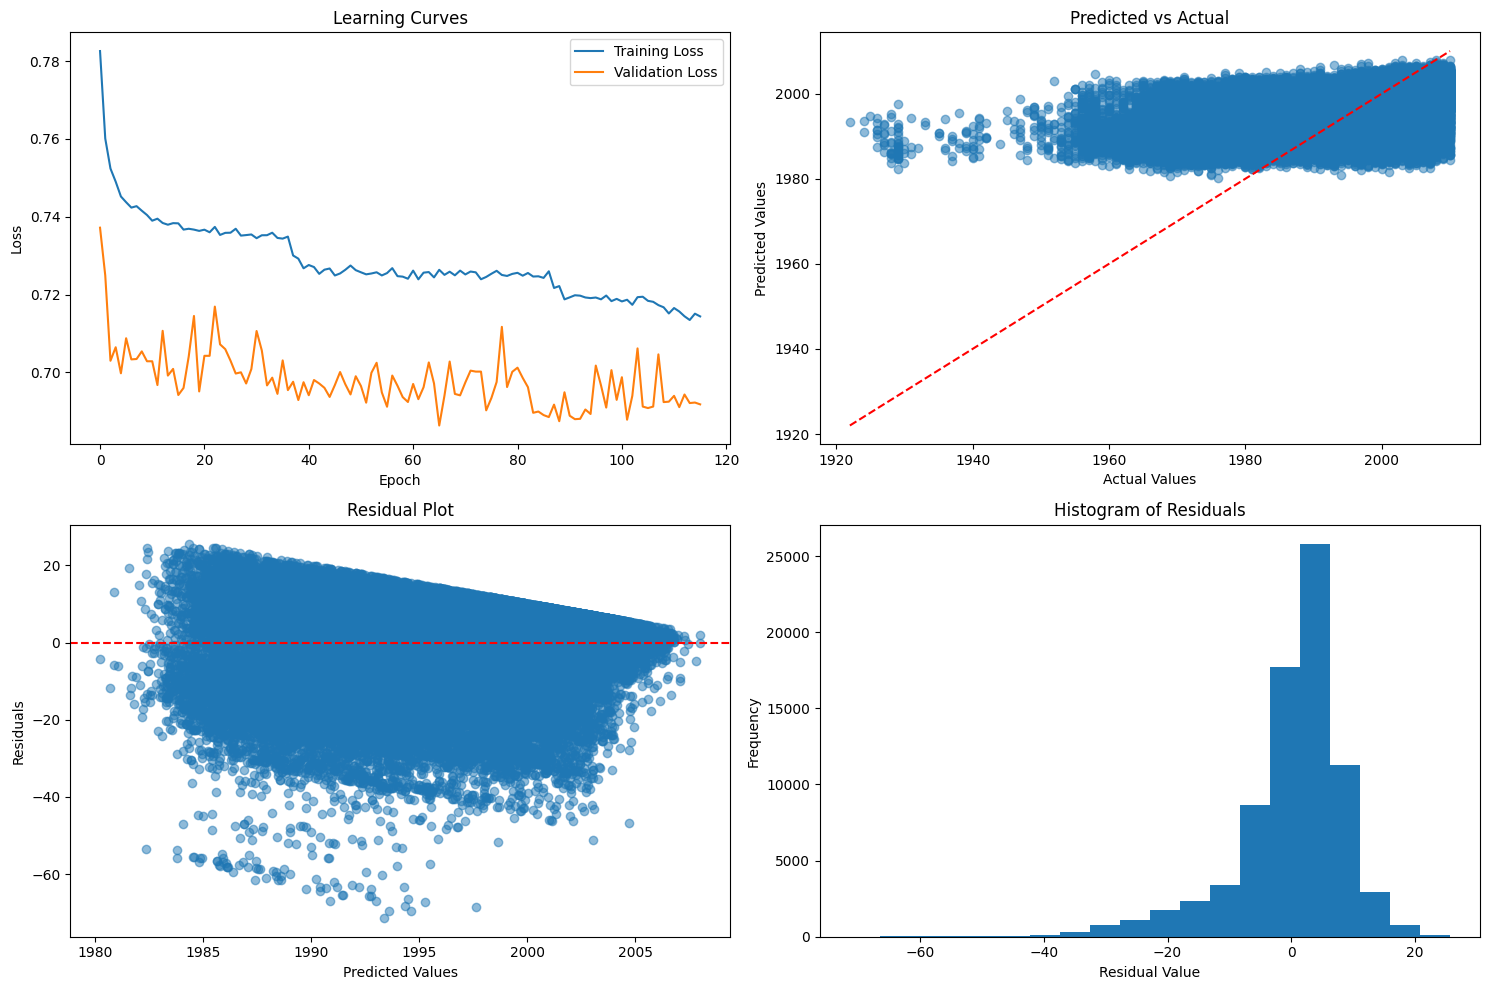

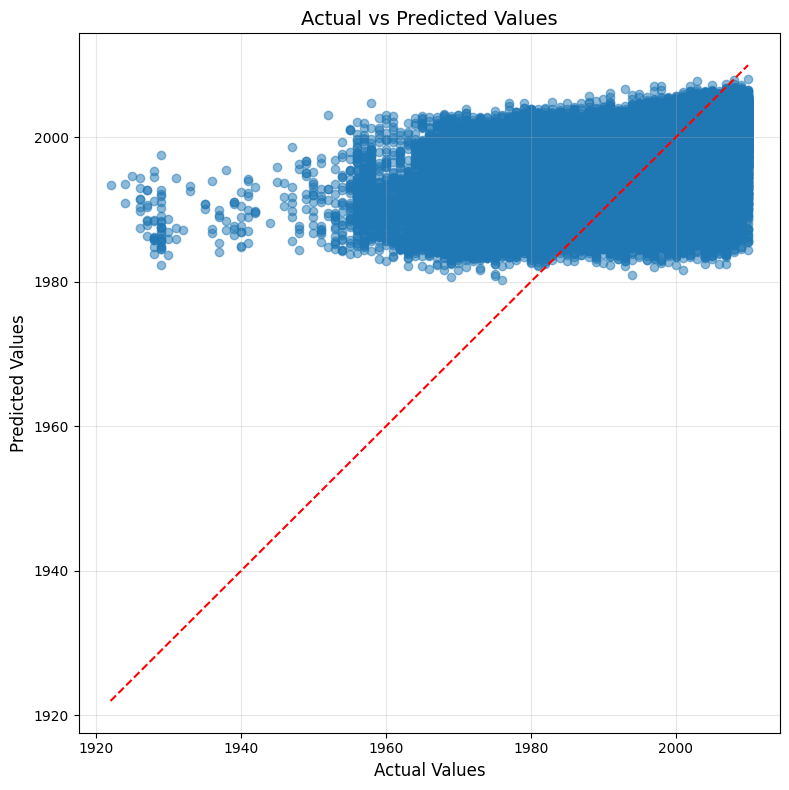


=== Interpretasi Hasil ===
Model MLP memiliki R² Score: 0.3067, yang berarti model mampu menjelaskan 30.67% variasi pada data target.
RMSE model adalah 9.1404, yang merupakan ukuran rata-rata kesalahan prediksi dalam unit yang sama dengan variabel target.
Model memiliki kemampuan prediksi yang terbatas dengan R² < 0.5

Metrik evaluasi mana yang terbaik?
- RMSE lebih mudah diinterpretasikan karena memiliki unit yang sama dengan target
- R² berguna untuk membandingkan performa model dengan baseline dan memberikan nilai yang dinormalisasi
- MSE memberikan bobot lebih pada kesalahan besar, cocok jika outlier merupakan masalah serius
- MAE tidak terlalu sensitif terhadap outlier dan lebih robust

Berdasarkan tujuan analisis:
MAE adalah metrik terbaik untuk dataset ini karena lebih resisten terhadap outlier dan distribusi error

=== K-Fold Cross Validation ===
Fold 1/5


KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import warnings
warnings.filterwarnings('ignore')

# Set seed untuk reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Load Dataset
# Asumsikan file .csv sudah di-upload
df = pd.read_csv('RegresiUTSTelkom.csv', header=None)
print(f"Dataset shape: {df.shape}")

# 2. Eksplorasi Data Awal
# Melihat statistik dasar data
print("\nStatistik Dasar:")
print(df.describe().T)

# Memeriksa nilai null
print("\nJumlah nilai null per kolom:")
print(df.isnull().sum())

# 3. Feature Engineering dan Pembersihan Data
# Memisahkan target (kolom 0) dan fitur (kolom lainnya)
X = df.iloc[:, 1:].copy()  # Semua kolom kecuali kolom 0
y = df.iloc[:, 0].copy()   # Kolom pertama sebagai target

print(f"\nJumlah fitur: {X.shape[1]}")
print(f"Jumlah sampel: {X.shape[0]}")

# 3.1 Deteksi dan penanganan outlier pada fitur menggunakan IQR method
def handle_outliers(df, method='clip'):
    """
    Handle outliers in the dataframe using IQR method
    method: 'clip' to clip values or 'remove' to remove rows with outliers
    """
    result_df = df.copy()

    for column in result_df.columns:
        Q1 = result_df[column].quantile(0.25)
        Q3 = result_df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'clip':
            result_df[column] = result_df[column].clip(lower_bound, upper_bound)
        elif method == 'remove':
            result_df = result_df[(result_df[column] >= lower_bound) &
                                  (result_df[column] <= upper_bound)]

    return result_df

# Penanganan outlier
X_cleaned = handle_outliers(X, method='clip')

# 3.2 Feature Selection menggunakan SelectKBest dan f_regression
# Memilih top k fitur terbaik
k = min(50, X.shape[1])  # Pilih maksimal 50 fitur atau jumlah fitur yang tersedia
selector = SelectKBest(f_regression, k=k)
X_selected = selector.fit_transform(X_cleaned, y)

# Mendapatkan indeks fitur yang dipilih
selected_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_indices]
print(f"\nFitur terpilih: {selected_feature_names.tolist()}")

# 3.3 Feature Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_selected)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 3.4 Dimensionality Reduction menggunakan PCA (opsional)
# Kita akan mencoba dengan dan tanpa PCA nanti
use_pca = False
if use_pca:
    pca = PCA(n_components=min(30, X_selected.shape[1]))
    X_pca = pca.fit_transform(X_scaled)
    print(f"\nDimensi setelah PCA: {X_pca.shape[1]}")
    print(f"Variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")
    X_final = X_pca
else:
    X_final = X_scaled

# 4. Split data menjadi training, validation dan test
X_train, X_temp, y_train, y_temp = train_test_split(X_final, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nJumlah sampel training: {X_train.shape[0]}")
print(f"Jumlah sampel validation: {X_val.shape[0]}")
print(f"Jumlah sampel testing: {X_test.shape[0]}")

# 5. Membuat Dataset dan DataLoader PyTorch
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 200
patience = 50  # Early stopping patience

# Create DataLoaders
train_dataset = RegressionDataset(X_train, y_train)
val_dataset = RegressionDataset(X_val, y_val)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 6. Mendefinisikan model MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
        super(MLP, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze()

# Dimensi input disesuaikan dengan jumlah fitur terpilih
input_dim = X_final.shape[1]
hidden_dims = [128, 64, 32]  # Arsitektur layer tersembunyi
dropout_rate = 0.3

# Inisialisasi model, loss function, dan optimizer
model = MLP(input_dim, hidden_dims, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# 7. Fungsi Training dan Validasi
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    return running_loss / len(val_loader.dataset)

# 8. Training Loop with Early Stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_state = None

print("\nMulai Training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# 9. Evaluasi model pada data testing
model.eval()
with torch.no_grad():
    # Get predictions for test data
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred_scaled = model(X_test_tensor).numpy()

    # Inverse transform untuk mendapatkan nilai asli
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 10. Menghitung metrik evaluasi
mse = mean_squared_error(y_test_actual, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("\n=== Evaluasi Model ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# 11. Visualisasi hasil
plt.figure(figsize=(15, 10))

# Plot learning curves
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')

# Plot predicted vs actual
plt.subplot(2, 2, 2)
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')

# Plot residuals
residuals = y_test_actual - y_pred
plt.subplot(2, 2, 3)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Histogram of residuals
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=20)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.tight_layout()
plt.show()

# Scatter plot aktual vs prediksi dengan garis identitas
plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted Values', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 12. Interpretasi dan Kesimpulan
print("\n=== Interpretasi Hasil ===")
print(f"Model MLP memiliki R² Score: {r2:.4f}, yang berarti model mampu menjelaskan {r2*100:.2f}% variasi pada data target.")
print(f"RMSE model adalah {rmse:.4f}, yang merupakan ukuran rata-rata kesalahan prediksi dalam unit yang sama dengan variabel target.")

if r2 > 0.7:
    print("Model memiliki kemampuan prediksi yang baik dengan R² > 0.7")
elif r2 > 0.5:
    print("Model memiliki kemampuan prediksi yang moderat dengan R² > 0.5")
else:
    print("Model memiliki kemampuan prediksi yang terbatas dengan R² < 0.5")

print("\nMetrik evaluasi mana yang terbaik?")
print("- RMSE lebih mudah diinterpretasikan karena memiliki unit yang sama dengan target")
print("- R² berguna untuk membandingkan performa model dengan baseline dan memberikan nilai yang dinormalisasi")
print("- MSE memberikan bobot lebih pada kesalahan besar, cocok jika outlier merupakan masalah serius")
print("- MAE tidak terlalu sensitif terhadap outlier dan lebih robust")

print("\nBerdasarkan tujuan analisis:")
if abs(r2) > 0.7:
    print("R² adalah metrik terbaik untuk dataset ini karena menunjukkan performa model yang kuat dalam menjelaskan variasi data")
elif rmse < mae:
    print("RMSE adalah metrik terbaik untuk dataset ini karena errornya lebih kecil dan kesalahan besar berdampak signifikan")
else:
    print("MAE adalah metrik terbaik untuk dataset ini karena lebih resisten terhadap outlier dan distribusi error")
